# Introduction
***

Amazon SageMaker NTM (Neural Topic Model) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

In this notebook we will use the Amazon SageMaker NTM algorithm to train a model on some example synthetic data. We will then use this model to classify (perform inference on) the data. The main goals of this notebook are to,

* create an AWS SageMaker training job on a data set to produce a NTM model,
* use the model to perform inference with an Amazon SageMaker endpoint.

In [1]:
import os
import sagemaker
import boto3
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-228889150161


## Training

Once the data is preprocessed and available in a recommended format the next step is to train our model on the data. There are number of parameters required by the NTM algorithm to configure the model and define the computational environment in which training will take place. The first of these is to point to a container image which holds the algorithms training and hosting code.

In [2]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/ntm:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/ntm:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/ntm:latest'}

An NTM model uses the following hyperparameters:

- **num_topics** - The number of topics or categories in the NTM model. 
- **feature_dim** - The size of the "vocabulary". In this case, this has been set to 1000 by the nytimes pyspark data prep.

In addition to these NTM model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

> Note: Try adjusting the mini_batch_size if running on a GPU. 

In [3]:
num_topics=20
vocabulary_size=1000
output = 's3://{}/data/nytimes-model/sagemaker-ntm'.format(sagemaker_session.default_bucket())

ntm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output,
                                    sagemaker_session=sagemaker_session)

ntm.set_hyperparameters(num_topics=num_topics,
                        feature_dim=vocabulary_size,
                        mini_batch_size=256)

We'll train against the bag-of-words extracted from the NY Times comments.

In [4]:
import boto3
s3_client = boto3.client('s3')
objects = s3_client.list_objects(Bucket=bucket, Prefix='data/nyt-record-io/training.rec')
training_key = objects['Contents'][0]['Key']
training_input = 's3://{}/{}'.format(bucket, training_key)

In [5]:
ntm.fit({'train': training_input})

INFO:sagemaker:Creating training-job with name: ntm-2018-06-03-13-46-51-763


....................
Docker entrypoint called with argument(s): train
[06/03/2018 13:49:58 INFO 140519950444352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[06/03/2018 13:49:58 INFO 140519950444352] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'1000', u'mini_batch_size': u'256', u'num_topics': u'20'}
[06/03/2018 13:49:58 INFO 140519950444352] Final configuration: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf

[06/03/2018 13:51:12 INFO 140519950444352] # Finished training epoch 4 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:51:12 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:51:12 INFO 140519950444352] Loss (name: value) total: 6.43215225521
[06/03/2018 13:51:12 INFO 140519950444352] Loss (name: value) kld: 0.0502889504685
[06/03/2018 13:51:12 INFO 140519950444352] Loss (name: value) recons: 6.38186329387
[06/03/2018 13:51:12 INFO 140519950444352] Loss (name: value) logppx: 6.43215225521
[06/03/2018 13:51:12 INFO 140519950444352] #quality_metric: host=algo-1, epoch=4, train total_loss <loss>=6.43215225521
[06/03/2018 13:51:12 INFO 140519950444352] patience losses:[6.4784255754144695, 6.4563392723162556, 6.4458407342742765] min patience loss:6.44584073427 current loss:6.43215225521 absolute loss difference:0.0136884790628
[06/03/2018 13:51:12 INFO 140519950444352] #progress_metric: host=algo-1, completed 8 % of epochs
#metrics {"Metrics": {"Max Batches Se

[06/03/2018 13:52:26 INFO 140519950444352] # Finished training epoch 8 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:52:26 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:52:26 INFO 140519950444352] Loss (name: value) total: 6.40626482865
[06/03/2018 13:52:26 INFO 140519950444352] Loss (name: value) kld: 0.0818534008773
[06/03/2018 13:52:26 INFO 140519950444352] Loss (name: value) recons: 6.32441143174
[06/03/2018 13:52:26 INFO 140519950444352] Loss (name: value) logppx: 6.40626482865
[06/03/2018 13:52:26 INFO 140519950444352] #quality_metric: host=algo-1, epoch=8, train total_loss <loss>=6.40626482865
[06/03/2018 13:52:26 INFO 140519950444352] patience losses:[6.4251446943826629, 6.4173179843882826, 6.4103312596138275] min patience loss:6.41033125961 current loss:6.40626482865 absolute loss difference:0.00406643096647
[06/03/2018 13:52:26 INFO 140519950444352] #progress_metric: host=algo-1, completed 16 % of epochs
#metrics {"Metrics": {"Max Batches 

[06/03/2018 13:53:40 INFO 140519950444352] # Finished training epoch 12 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:53:40 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:53:40 INFO 140519950444352] Loss (name: value) total: 6.3874256554
[06/03/2018 13:53:40 INFO 140519950444352] Loss (name: value) kld: 0.105909884999
[06/03/2018 13:53:40 INFO 140519950444352] Loss (name: value) recons: 6.28151576778
[06/03/2018 13:53:40 INFO 140519950444352] Loss (name: value) logppx: 6.3874256554
[06/03/2018 13:53:40 INFO 140519950444352] #quality_metric: host=algo-1, epoch=12, train total_loss <loss>=6.3874256554
[06/03/2018 13:53:40 INFO 140519950444352] patience losses:[6.4026931103029403, 6.3988621318896204, 6.3937947152192107] min patience loss:6.39379471522 current loss:6.3874256554 absolute loss difference:0.00636905981469
[06/03/2018 13:53:40 INFO 140519950444352] #progress_metric: host=algo-1, completed 24 % of epochs
#metrics {"Metrics": {"Max Batches See

[06/03/2018 13:54:53 INFO 140519950444352] # Finished training epoch 16 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:54:53 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:54:53 INFO 140519950444352] Loss (name: value) total: 6.37473626532
[06/03/2018 13:54:53 INFO 140519950444352] Loss (name: value) kld: 0.127532463857
[06/03/2018 13:54:53 INFO 140519950444352] Loss (name: value) recons: 6.24720378984
[06/03/2018 13:54:53 INFO 140519950444352] Loss (name: value) logppx: 6.37473626532
[06/03/2018 13:54:53 INFO 140519950444352] #quality_metric: host=algo-1, epoch=16, train total_loss <loss>=6.37473626532
[06/03/2018 13:54:53 INFO 140519950444352] patience losses:[6.384117433073607, 6.3813847010617426, 6.3777896747687937] min patience loss:6.37778967477 current loss:6.37473626532 absolute loss difference:0.00305340944794
[06/03/2018 13:54:53 INFO 140519950444352] #progress_metric: host=algo-1, completed 32 % of epochs
#metrics {"Metrics": {"Max Batches 

[06/03/2018 13:56:07 INFO 140519950444352] # Finished training epoch 20 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:56:07 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:56:07 INFO 140519950444352] Loss (name: value) total: 6.36803244457
[06/03/2018 13:56:07 INFO 140519950444352] Loss (name: value) kld: 0.137846018135
[06/03/2018 13:56:07 INFO 140519950444352] Loss (name: value) recons: 6.23018641818
[06/03/2018 13:56:07 INFO 140519950444352] Loss (name: value) logppx: 6.36803244457
[06/03/2018 13:56:07 INFO 140519950444352] #quality_metric: host=algo-1, epoch=20, train total_loss <loss>=6.36803244457
[06/03/2018 13:56:07 INFO 140519950444352] patience losses:[6.3728409720208363, 6.3704419296640191, 6.3693241218211121] min patience loss:6.36932412182 current loss:6.36803244457 absolute loss difference:0.00129167724767
[06/03/2018 13:56:07 INFO 140519950444352] #progress_metric: host=algo-1, completed 40 % of epochs
#metrics {"Metrics": {"Max Batches

[06/03/2018 13:57:21 INFO 140519950444352] # Finished training epoch 24 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:57:21 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:57:21 INFO 140519950444352] Loss (name: value) total: 6.36277991601
[06/03/2018 13:57:21 INFO 140519950444352] Loss (name: value) kld: 0.148876987166
[06/03/2018 13:57:21 INFO 140519950444352] Loss (name: value) recons: 6.21390292484
[06/03/2018 13:57:21 INFO 140519950444352] Loss (name: value) logppx: 6.36277991601
[06/03/2018 13:57:21 INFO 140519950444352] #quality_metric: host=algo-1, epoch=24, train total_loss <loss>=6.36277991601
[06/03/2018 13:57:21 INFO 140519950444352] patience losses:[6.3669901998549543, 6.3650705456116041, 6.3638019700124477] min patience loss:6.36380197001 current loss:6.36277991601 absolute loss difference:0.00102205400022
[06/03/2018 13:57:21 INFO 140519950444352] #progress_metric: host=algo-1, completed 48 % of epochs
#metrics {"Metrics": {"Max Batches

[06/03/2018 13:58:36 INFO 140519950444352] # Finished training epoch 28 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:58:36 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:58:36 INFO 140519950444352] Loss (name: value) total: 6.35857422982
[06/03/2018 13:58:36 INFO 140519950444352] Loss (name: value) kld: 0.1539169775
[06/03/2018 13:58:36 INFO 140519950444352] Loss (name: value) recons: 6.20465724703
[06/03/2018 13:58:36 INFO 140519950444352] Loss (name: value) logppx: 6.35857422982
[06/03/2018 13:58:36 INFO 140519950444352] #quality_metric: host=algo-1, epoch=28, train total_loss <loss>=6.35857422982
[06/03/2018 13:58:36 INFO 140519950444352] patience losses:[6.3614416006315562, 6.3602800505148931, 6.3593219759550736] min patience loss:6.35932197596 current loss:6.35857422982 absolute loss difference:0.000747746136522
[06/03/2018 13:58:36 INFO 140519950444352] Bad epoch: loss has not improved (enough). Bad count:2
[06/03/2018 13:58:36 INFO 1405199504

[06/03/2018 13:59:50 INFO 140519950444352] # Finished training epoch 32 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 13:59:50 INFO 140519950444352] Metrics for Training:
[06/03/2018 13:59:50 INFO 140519950444352] Loss (name: value) total: 6.3520228549
[06/03/2018 13:59:50 INFO 140519950444352] Loss (name: value) kld: 0.16312203669
[06/03/2018 13:59:50 INFO 140519950444352] Loss (name: value) recons: 6.18890082256
[06/03/2018 13:59:50 INFO 140519950444352] Loss (name: value) logppx: 6.3520228549
[06/03/2018 13:59:50 INFO 140519950444352] #quality_metric: host=algo-1, epoch=32, train total_loss <loss>=6.3520228549
[06/03/2018 13:59:50 INFO 140519950444352] patience losses:[6.3570873304969906, 6.3561376146701951, 6.3535902485328632] min patience loss:6.35359024853 current loss:6.3520228549 absolute loss difference:0.00156739363399
[06/03/2018 13:59:50 INFO 140519950444352] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen

[06/03/2018 14:01:04 INFO 140519950444352] # Finished training epoch 36 on 246918 examples from 965 batches, each of size 256.
[06/03/2018 14:01:04 INFO 140519950444352] Metrics for Training:
[06/03/2018 14:01:04 INFO 140519950444352] Loss (name: value) total: 6.34755487738
[06/03/2018 14:01:04 INFO 140519950444352] Loss (name: value) kld: 0.17104971046
[06/03/2018 14:01:04 INFO 140519950444352] Loss (name: value) recons: 6.17650516268
[06/03/2018 14:01:04 INFO 140519950444352] Loss (name: value) logppx: 6.34755487738
[06/03/2018 14:01:04 INFO 140519950444352] #quality_metric: host=algo-1, epoch=36, train total_loss <loss>=6.34755487738
[06/03/2018 14:01:04 INFO 140519950444352] patience losses:[6.3505619436965706, 6.3493679723591381, 6.3483884154206116] min patience loss:6.34838841542 current loss:6.34755487738 absolute loss difference:0.000833538035655
[06/03/2018 14:01:04 INFO 140519950444352] Bad epoch: loss has not improved (enough). Bad count:2
[06/03/2018 14:01:04 INFO 140519950

===== Job Complete =====
Billable seconds: 808


## Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document or comment.

This is simplified by the deploy function provided by the Amazon SageMaker Python SDK.

In [6]:
ntm_predictor = ntm.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge',
                          endpoint_name='ntm-nyt')

INFO:sagemaker:Creating model with name: ntm-2018-06-03-14-03-37-919
INFO:sagemaker:Creating endpoint with name ntm-nyt


--------------------------------------------------------------------------!

## Model Exploration 

This next section is based on ["An Introduction to SageMaker Neural Topic Model"](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb).  While this section is not required for model deployment, it does offer some explaination of the topic. 

In [7]:
!pip install mxnet 
import mxnet as mx

    100% |████████████████████████████████| 26.1MB 47kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
model_path = os.path.join('data/nytimes-model/sagemaker-ntm', ntm._current_job_name, 'output/model.tar.gz')
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')
!tar -xzvf 'downloaded_model.tar.gz'
!unzip -o model_algo-1

data/nytimes-model/sagemaker-ntm/ntm-2018-06-03-13-46-51-763/output/model.tar.gz
model_algo-1
Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [12]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [13]:
!pip install wordcloud
import wordcloud as wc

    100% |████████████████████████████████| 174kB 5.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for wordcloud ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/40/7c/d768cb5022ec6aa5611728339886bc1e9f0b629547f39237fd
Successfully built wordcloud
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import boto3
import json

s3 = boto3.resource('s3')
obj = s3.Object('sagemaker-us-east-1-228889150161','data/nyt-features/vocab.json')
obj.download_file('vocab.json')

def load_vocab():
    with open('vocab.json', 'r') as json_file:
        return json.load(json_file)

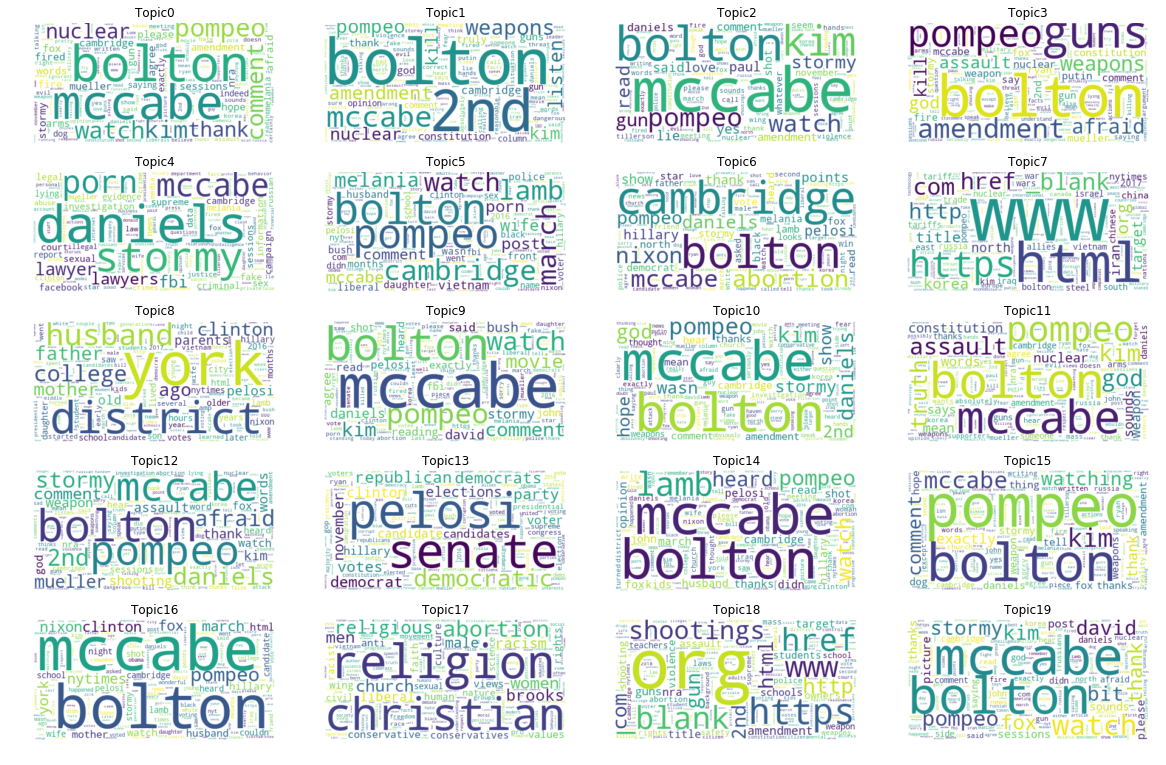

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

word_to_id = load_vocab()

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
